#LAB 1: VGGNet & ResNet

<h4><div style="text-align: right"> Due date: 15:00 Oct 10, 2024.  </div> <br>
<div style="text-align: right"> Please upload your file and final-report at PLATO before the class in the form of [ID_Name_Lab1.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span>
- You must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[201924451] [김태훈]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-10-09 02:09:57.784339


In [2]:
#####################################################################
# In order to use GPU acceleration, you must change runtime type.
# See the menu bar above.
# "Runtime" -> "Change runtime type"  -> "Hardware accelerator"
# Change 'None' to 'GPU', then run the code below.
#####################################################################

import sys
import platform
import torch

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)

OS information
Linux-6.1.85+-x86_64-with-glibc2.35

Is GPU available?
True

GPU information
Wed Oct  9 02:10:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   58C    P8              14W /  72W |      4MiB / 23034M

## 1. VGGNet with PyTorch

### Implementing VGGNet

> 1. **Dataset**
>> - Images from the first three categories in CIFAR-10. (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
>> - Augmented with flipping and random cropping.
>
> 2. **Network architecture**
>> - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
>> - ReLU activation.
>> - No dropout for simplicity.
>> - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).
>> - **Conv2d -> BatchNorm2d -> ReLU**
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1OiTmrplD9gOrEJizLChyLp31R0QtoeHv" alt="no_image" style="width: 550px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1bBvAOdJeskMMyOrZtBCCnkEEgq9PgjX9" alt="no_image" style="width: 250px;"/> </td>
>> </tr></table>
>>
>> <font size="0.5"> Figure from <br>
>> [1] https://www.quora.com/What-is-the-VGG-neural-network </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 20 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                            train=True,
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                           train=False,
                           transform=transform_test)

STEP 1: LOADING DATASET


100%|██████████| 170498071/170498071 [00:13<00:00, 12858581.08it/s]


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10/


In [5]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))

reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [6]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [7]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=128,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset,
                                          batch_size=100,
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

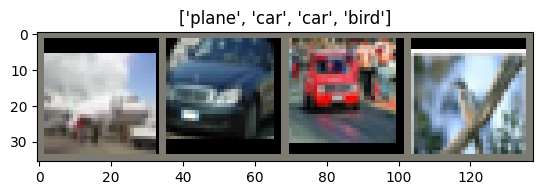

In [10]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=4,
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 1.1 Write code (VGG 16) [3 points]

In [11]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

#############
# CODE HERE #
#############

## BatchNorm2d(in_channel)

cfg = [64, 64, 'MP', 128, 128, 'MP',256,256,256,'MP', 512, 512, 512, 'MP', 512, 512, 512, 'MP']

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.VGG16 = self._make_layers(cfg)
        self.classifier = nn.Sequential(
            nn.Linear(512,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,3)
        )

    def forward(self, x):
        out = self.VGG16(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

    def _make_layers(self,cfg):
        layers = []
        in_channels=3
        for x in cfg:
          assert x=='MP' or isinstance(x,int)
          if x=='MP':
            layers  = layers+ [nn.MaxPool2d(kernel_size=2)]
          else:
            layers+=[nn.Conv2d(in_channels,x,kernel_size=3,padding='same')]
            layers+=[nn.BatchNorm2d(x)]
            layers+=[nn.ReLU()]
            in_channels=x

        return nn.Sequential(*layers)

STEP 3: CREATE MODEL CLASS (VGG16)


In [12]:
print('STEP 4: INSTANTIATE MODEL CLASS')

model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  15249987


VGG(
  (VGG16): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (15)

In [13]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the VGG 16 model and print test accuracy for every epochs [2 points]

In [14]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20

#############
# CODE HERE #
#############
iter = 0
vggnetloss = []
vggnetaccuracy = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities

        images = images.to(device)
        labels = labels.to(device)


        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()




    # Calculate Accuracy
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in test_loader:
        # Load images with gradient accumulation capabilities
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total

        # Print Loss
    print('Epochs: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))
    vggnetloss.append(loss.item())
    vggnetaccuracy.append(accuracy)

STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 0.9076752066612244. Accuracy: 84.63333333333334
Epochs: 1. Loss: 0.3859376013278961. Accuracy: 87.83333333333333
Epochs: 2. Loss: 0.31071463227272034. Accuracy: 88.76666666666667
Epochs: 3. Loss: 0.24999915063381195. Accuracy: 90.3
Epochs: 4. Loss: 0.1045956090092659. Accuracy: 89.76666666666667
Epochs: 5. Loss: 0.09065283089876175. Accuracy: 89.66666666666667
Epochs: 6. Loss: 0.0714077427983284. Accuracy: 90.53333333333333
Epochs: 7. Loss: 0.0646723285317421. Accuracy: 90.8
Epochs: 8. Loss: 0.07163791358470917. Accuracy: 90.5
Epochs: 9. Loss: 0.08117971569299698. Accuracy: 91.8
Epochs: 10. Loss: 0.00668993778526783. Accuracy: 91.6
Epochs: 11. Loss: 0.01310143992304802. Accuracy: 91.06666666666666
Epochs: 12. Loss: 0.015267569571733475. Accuracy: 89.8
Epochs: 13. Loss: 0.006410038564354181. Accuracy: 92.66666666666667
Epochs: 14. Loss: 0.3991355001926422. Accuracy: 92.3
Epochs: 15. Loss: 0.12119697779417038. Accuracy: 91.73333333333333
Epochs: 1

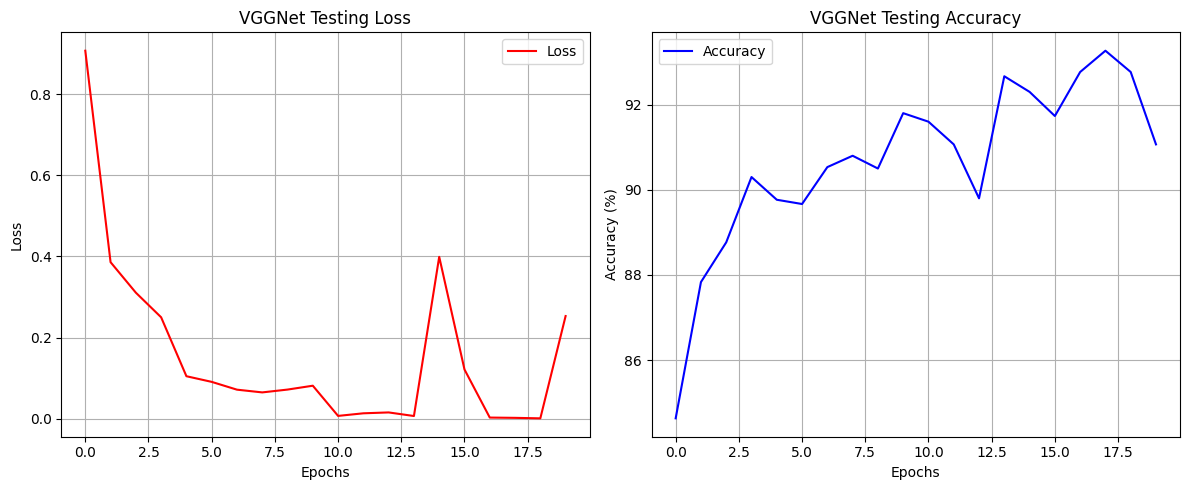

In [15]:
import matplotlib.pyplot as plt
epochs = range(0, len(vggnetloss))

# 그래프 크기 설정
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, vggnetloss, 'r-', label='Loss')
plt.title('VGGNet Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, vggnetaccuracy, 'b-', label='Accuracy')
plt.title('VGGNet Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 2. ResNet with PyTorch

### Implementing ResNet

> 1. **Dataset**
>> - The same dataset used for VGGNet
>
> 2. **Network architecture**
>> - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
>> - ReLU activation.
>> - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
>> - No dropout for simplicity.
>> - Batch-normalization after every convolution.
>>
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1ZYDfpVBFBvQnVezVcJqRxwh09rUVmxwD" alt="no_image" style="width: 500px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1JNEea1G-5yOKVLmSCkiYAEJ0HXOys0CR" alt="no_image" style="width: 300px;"/> </td>
>> </tr></table>
>>
>> <img src="https://docs.google.com/uc?export=download&id=1vY0ys5KAZmMlOKk8Dcv7eAV8pZ9cawzJ" alt="no_image" style="width: 870px;"/>
>>
>> <font size="0.5"> Figures from <br>
>> [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br>
>> [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 15 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
>

### 2.1 Implement ResNet50 and train it with the CIFAR 10 dataset [4 points]

In [16]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')

cfg = [3,4,6,3]

class ResNet_block(nn.Module):
    def __init__(self, in_c, intra_c, out_c, down_sample = False, expand = False):
        super(ResNet_block, self).__init__()

        if down_sample:
          stride=2
        else:
          stride=1
        self.down_sample = down_sample
        self.expand = expand
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_c,intra_c,kernel_size=1,stride=stride),
            nn.BatchNorm2d(intra_c),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(intra_c,intra_c,kernel_size=3,padding='same'),
            nn.BatchNorm2d(intra_c),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(intra_c,out_c,kernel_size=1),
            nn.BatchNorm2d(out_c),

        )

        if self.down_sample or self.expand:
          self.convert_id = nn.Sequential(
              nn.Conv2d(in_c,out_c,kernel_size=1,stride=stride),
              nn.BatchNorm2d(out_c)
          )
        else:
          self.convert_id = None

#############
# CODE HERE #
#############

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        if self.down_sample or self.expand:
            identity = self.convert_id(x)
        out = F.relu(out + identity)
        return out

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.init_block = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.ResBlock1 = self._make_layers(64,64,256,cfg[0],False)
        self.ResBlock2 = self._make_layers(256,128,512,cfg[1],True)
        self.ResBlock3 = self._make_layers(512,256,1024,cfg[2],True)
        self.ResBlock4 = self._make_layers(1024,512,2048,cfg[3],True)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048,3)

#############
# CODE HERE #
#############


    def forward(self, x):
        out = self.init_block(x)
        out = self.ResBlock1(out)
        out = self.ResBlock2(out)
        out = self.ResBlock3(out)
        out = self.ResBlock4(out)
        out = self.avgpool(out)
        out= out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

    def _make_layers(self, in_c, intra_c, out_c, num_block, down_sample):
        layers = []
        # first block
        layers.append(ResNet_block(in_c = in_c, intra_c = intra_c, out_c = out_c, down_sample = down_sample,expand = True ))
        # intermediate blocks
        for _ in range(num_block - 1):
            layers.append(ResNet_block(in_c = out_c, intra_c = intra_c, out_c = out_c, down_sample = False,expand=False))

        return nn.Sequential(*layers)


print('STEP 4: INSTANTIATE MODEL CLASS')
#############
# CODE HERE #
#############
model = ResNet()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  23533059


ResNet(
  (init_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ResBlock1): Sequential(
    (0): ResNet_block(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv3): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (convert_id): Sequential(
        (0): Conv2d(64, 256, kerne

### 2.2 Print test accuracy for every epochs. [1 points]

In [17]:
print('STEP 5: INSTANTIATE LOSS CLASS')
#############
# CODE HERE #
#############
criterion = nn.CrossEntropyLoss()
print('STEP 6: INSTANTIATE OPTIMIZER CLASS')
#############
# CODE HERE #
#############
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

print('STEP 7: TRAIN THE MODEL')
num_epochs = 15

#############
# CODE HERE #
#############
iter = 0
resnetloss = []
resnetaccuracy = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities

        images = images.to(device)
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()




    # Calculate Accuracy
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in test_loader:
        # Load images with gradient accumulation capabilities
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total

        # Print Loss
    print('Epochs: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))
    resnetloss.append(loss.item())
    resnetaccuracy.append(accuracy)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 0.7900087237358093. Accuracy: 67.93333333333334
Epochs: 1. Loss: 0.6488252878189087. Accuracy: 70.53333333333333
Epochs: 2. Loss: 0.4514048099517822. Accuracy: 78.56666666666666
Epochs: 3. Loss: 0.6264361143112183. Accuracy: 81.2
Epochs: 4. Loss: 0.2360609769821167. Accuracy: 80.83333333333333
Epochs: 5. Loss: 0.3312324583530426. Accuracy: 82.0
Epochs: 6. Loss: 0.36883044242858887. Accuracy: 82.46666666666667
Epochs: 7. Loss: 0.16199477016925812. Accuracy: 84.2
Epochs: 8. Loss: 0.4512772858142853. Accuracy: 83.6
Epochs: 9. Loss: 0.41187360882759094. Accuracy: 79.1
Epochs: 10. Loss: 0.17110250890254974. Accuracy: 81.93333333333334
Epochs: 11. Loss: 0.08137622475624084. Accuracy: 85.86666666666666
Epochs: 12. Loss: 0.21038700640201569. Accuracy: 85.1
Epochs: 13. Loss: 0.20455020666122437. Accuracy: 83.96666666666667
Epochs: 14. Loss: 0.06645738333463669. Accuracy: 84.03333333333333

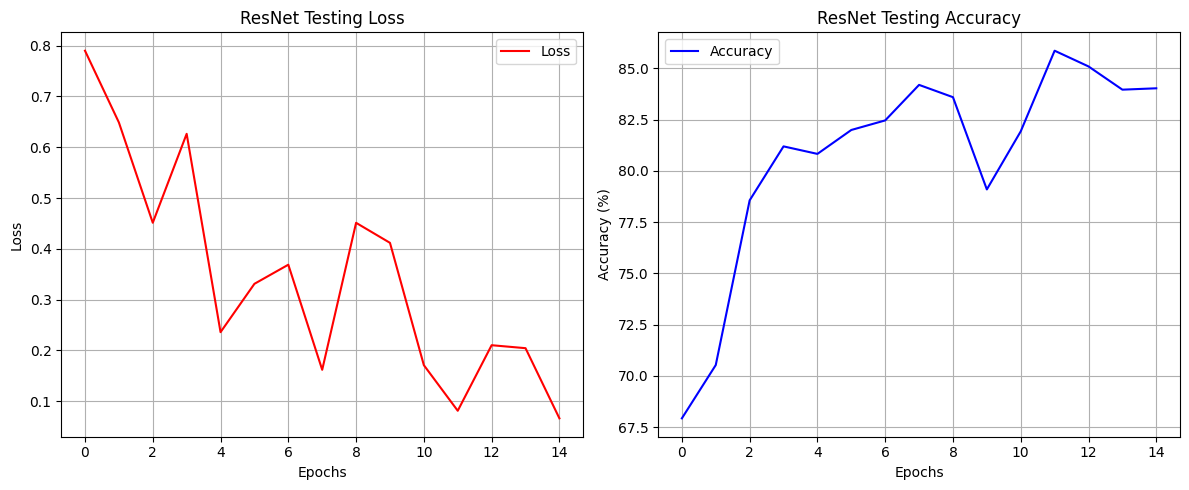

In [18]:
epochs = range(0, len(resnetloss))

# 그래프 크기 설정
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, resnetloss, 'r-', label='Loss')
plt.title('ResNet Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, resnetaccuracy, 'b-', label='Accuracy')
plt.title('ResNet Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()